In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

In [2]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [3]:
import sys
sys.path.append('..')
from xDL.models.NAMLSS import NAMLSS

In [4]:
namlss = NAMLSS(
    "target ~  -1 + MLP(MedInc) + MLP(AveOccup) + MLP(AveBedrms) + MLP(Population)+  MLP(Latitude; encoding=one_hot; n_bins=50; hidden_dims=[12, 12, 12]) + MLP(Longitude):MLP(AveRooms)", 
    data=data, 
    family="Normal", 
    feature_dropout=0.0001,
    loss="nll"
    )


--- Preprocessing ---


8it [00:08,  1.07s/it]
7it [00:00, 257.43it/s]


In [5]:
def KL_Divergence(y_true, y_hat):
    t = tfd.Normal(loc=y_true, scale=tf.math.reduce_std(y_true))
    p = tfd.Normal(loc=y_hat, scale=tf.math.reduce_std(y_true))  
    kl = tf.reduce_mean(tfd.kl_divergence(t, p, allow_nan_stats=True))
    return kl

namlss.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss={"output":namlss.Loss}, 
    metrics={"output": KL_Divergence, "summed_output":"mse"}
    )

# Train the model
namlss.fit(namlss.training_dataset, epochs=150, validation_data=namlss.validation_dataset)

# Evaluate the model
loss = namlss.evaluate(namlss.validation_dataset)
print("Test Loss:", loss)

Epoch 1/150
------------- Network architecture --------------
MedInc -> MLP(feature=MedInc, n_params=12800) -> output dimension=2
AveOccup -> MLP(feature=AveOccup, n_params=12800) -> output dimension=2
AveBedrms -> MLP(feature=AveBedrms, n_params=12800) -> output dimension=2
Population -> MLP(feature=Population, n_params=12800) -> output dimension=2
Latitude -> MLP(feature=Latitude, n_params=948) -> output dimension=2
Longitude_._AveRooms -> MLP(feature=Longitude_._AveRooms, n_params=12928) -> output dimension=2
16/16 [==============================] - 10s 83ms/step - loss: 1.5062 - output_loss: 1.5062 - output_KL_Divergence: 1.3262 - summed_output_mse: 1.4831 - val_loss: 1.1924 - val_output_loss: 1.1924 - val_output_KL_Divergence: 0.8029 - val_summed_output_mse: 0.8455
Epoch 2/150
16/16 [==============================] - 1s 45ms/step - loss: 12.6465 - output_loss: 12.6465 - output_KL_Divergence: 0.9017 - summed_output_mse: 0.9647 - val_loss: 1.0422 - val_output_loss: 1.0422 - val_outp

(100, 100, 2)


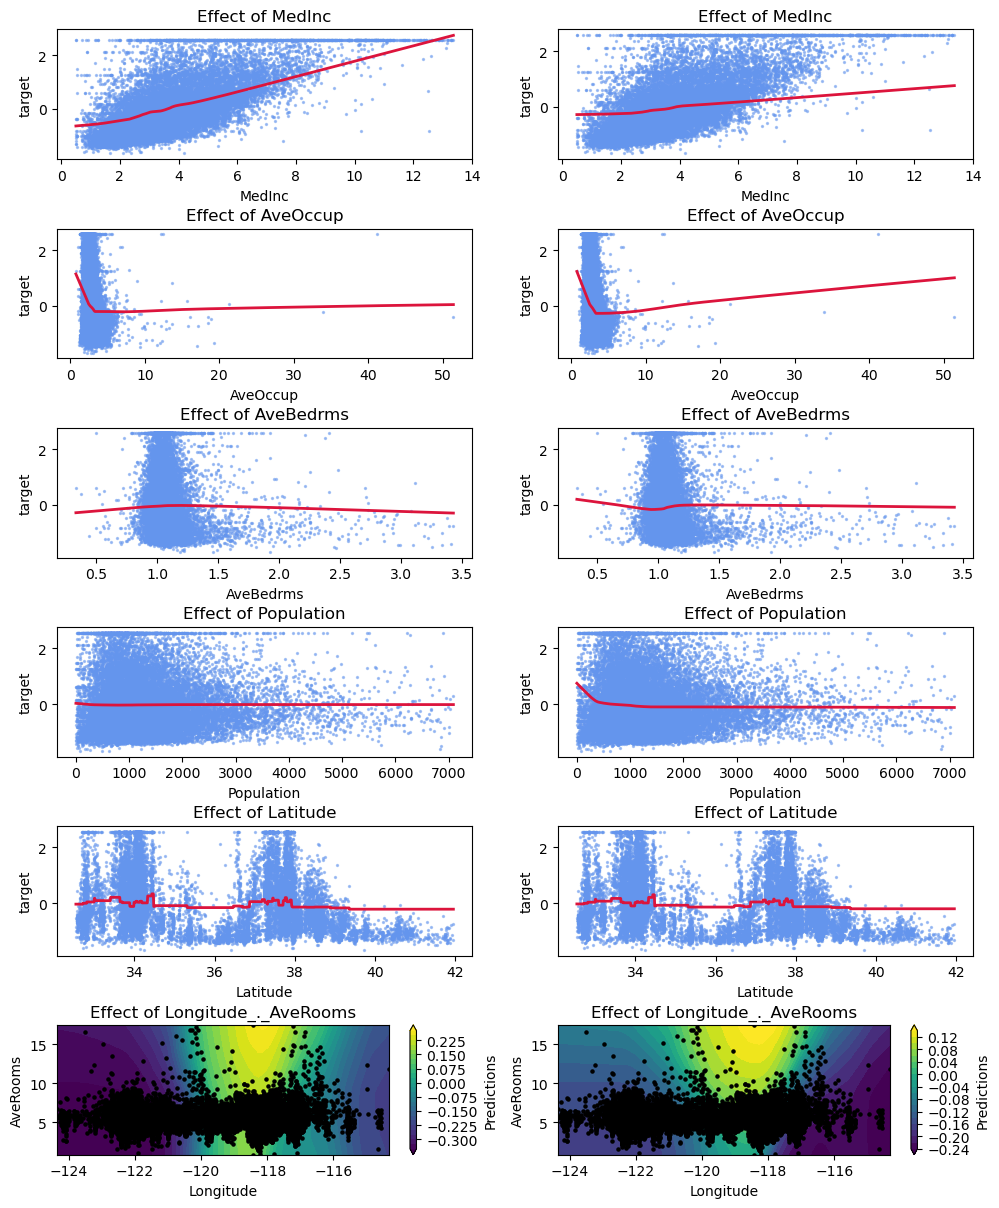

In [6]:
namlss.plot()

In [7]:
namlss.plot_all_interactive()

(100, 100, 2)


16/16 [==============================] - 1s 14ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


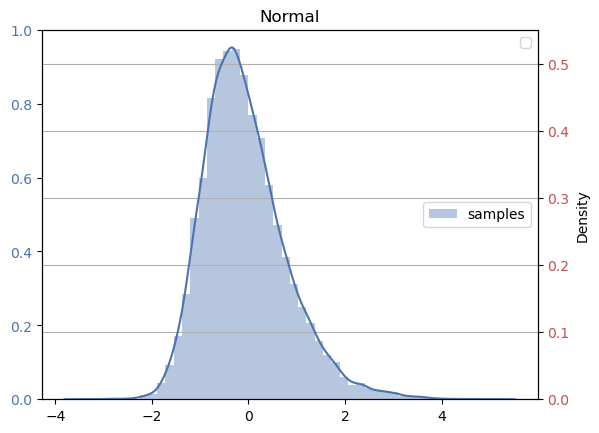

In [8]:
namlss.plot_dist()